In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on August 13 2018
@author: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    
    

In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import Zernike_Module
from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit

In [5]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

In [42]:
#specify number of observation which you want to analyze
obs='8600'
#specify single number which specifies which spot you want to anallyze - values are from 0 to 100, '55' is in the center of the detector 
single_number='55'
#load scientific and variance image
#sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
#var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')

image_index=55
if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')



obs_int=int(obs)
obs_possibilites=np.array([8564,8567,8570,8573,8603,8600,8606,8609,8612,8615])
z4Input_possibilites=np.array([14,10.5,7,3.5,0,0,-3.5,-7,-10.5,-14])
z4Input=z4Input_possibilites[obs_possibilites==obs_int][0]

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','flux']  
"""
@param z4                     defocus parameter - if you give the observations number it will automaticly adjust but you can also pass the value manually below
@param z5-z11                 Zernike coefficents, following Noel convention

@param hscFrac                controls the size of the central obscuration (name is relic of the code when it was used for Hyper Suprime cam project)
@param hscFrac                controls the size of the struts
@param dxFocal, dyFocal       positions of central obscuraiton, i.e., where on detector is the spot
@param slitFrac               size of the slit 
@param slitFrac_dy            position of the slit 

@param radiometricEffect      parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponent    parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])

@param x_ilum, y_ilum         positions of the centrer of the nonuniform illumination
@param minorAxis,pupilAngle   describing ellipse if the exit puppil is not circle

@param grating_lines          how many effective lines does the grating has
@param scattering_radius      minimal radius to which extended the scattering
@param scattering_slope       slope of scattering
@param scattering_amplitude   amplitude of scattering compared to optical PSF

@param pixel_effect           parameters describing charge-diffusion effect, modelled with Gaussian with sigma=pixel_effect
@param flux                   total number of counts in the modelled image compared to the data (probably around 1)
"""

allparameters_proposal=np.array([z4Input,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,
                                 -0.2,0.00,0.99,0.0,
                                 50000,50,2.5,10**-1.2,
                                 0.47,1.0])

#This is part of the code that I use to create starting point for the parallel tempering code when searching for best fit values on the cluster
nT=4
parInit1=create_parInit(allparameters_proposal)
parInit2=create_parInit(allparameters_proposal)
parInit3=create_parInit(allparameters_proposal)
parInit4=create_parInit(allparameters_proposal)
parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])

if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1)   

modelP =LNP_PFS(sci_image,var_image)

In [43]:
allparameters_proposal

array([     0.        ,      0.09      ,      0.02      ,     -0.1       ,
            0.        ,      0.1       ,      0.02      ,      0.2       ,
            0.65      ,      0.1       ,      0.        ,      0.        ,
            0.08      ,      0.        ,      0.7       ,      2.        ,
           -0.2       ,      0.        ,      0.99      ,      0.        ,
        50000.        ,     50.        ,      2.5       ,      0.06309573,
            0.47      ,      1.        ])

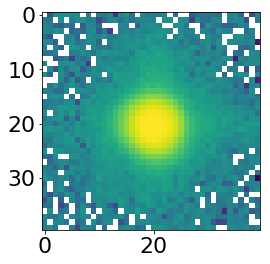

In [44]:
plt.imshow(sci_image,norm=LogNorm())

In [47]:
%prun model(allparameters_proposal)

oversampling of optPSF is: 20.0135710609
oversampling of optPsf_downsampled is: 5
 

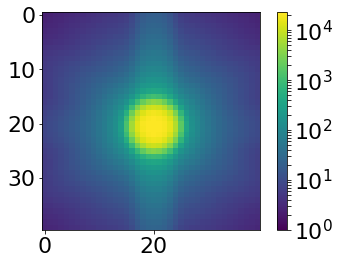

In [46]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

# Preliminary analysis

## some functions I still need -deprecated

In [ ]:
def create_res_data(FFTTest_fiber_and_pixel_convolved_downsampled_40,mask=None,custom_cent=None,size_pixel=None):
    
    if size_pixel is None:
        size_pixel=7.5
    
    image_shape=np.array(FFTTest_fiber_and_pixel_convolved_downsampled_40.shape)
    if custom_cent is None:
        xs0=0
        ys0=0
    else:

        xs0=(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40)[0]-int(image_shape[0]/2))*size_pixel
        ys0=(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40)[1]-int(image_shape[0]/2))*size_pixel
    pointsx = np.linspace(-(int(image_shape[0]*size_pixel)-size_pixel)/2,(int(image_shape[0]*size_pixel)-size_pixel)/2,num=int(image_shape[0]))
    pointsy = np.linspace(-(int(image_shape[0]*size_pixel)-size_pixel)/2,(int(image_shape[0]*size_pixel)-size_pixel)/2,num=int(image_shape[0]))
    xs, ys = np.meshgrid(pointsx, pointsy)
    r0 = np.sqrt((xs-xs0)** 2 + (ys-ys0)** 2)
    
    if mask is None:
        mask=np.ones((FFTTest_fiber_and_pixel_convolved_downsampled_40.shape[0],FFTTest_fiber_and_pixel_convolved_downsampled_40.shape[1]))
    
    distances=range(int(image_shape[0]/2*size_pixel*1.2))

    res_test_data=[]
    for r in distances:
        pixels_upper_limit=(mask*FFTTest_fiber_and_pixel_convolved_downsampled_40)[r0<(r+size_pixel)]
        pixels_lower_limit=(mask*FFTTest_fiber_and_pixel_convolved_downsampled_40)[r0<(r)]
        
        mask_upper_limit=mask[r0<(r+size_pixel)]
        mask_lower_limit=mask[r0<(r)]
        
        number_of_valid_pixels=np.sum(mask_upper_limit)-np.sum(mask_lower_limit)
        
        if number_of_valid_pixels==0:
            res_test_data.append(0)
        else:                  
            average_flux=(np.sum(pixels_upper_limit)-np.sum(pixels_lower_limit))/number_of_valid_pixels
            res_test_data.append(average_flux)        

    return res_test_data 

def find_centroid_of_flux(image):
    x_center=[]
    y_center=[]

    I_x=[]
    for i in range(image.shape[1]):
        I_x.append([i,np.sum(image[:,i])])

    I_x=np.array(I_x)

    I_y=[]
    for i in range(image.shape[0]):
        I_y.append([i,np.sum(image[i])])

    I_y=np.array(I_y)


    x_center=(np.sum(I_x[:,0]*I_x[:,1])/np.sum(I_x[:,1]))
    y_center=(np.sum(I_y[:,0]*I_y[:,1])/np.sum(I_y[:,1]))

    return(x_center,y_center)

def create_mask_100(FFTTest_fiber_and_pixel_convolved_downsampled_40,semi=None,central_cut_size=None):
    
    if central_cut_size is None:
        central_cut_size=6
            
    central_position=np.array(find_centroid_of_flux(FFTTest_fiber_and_pixel_convolved_downsampled_40))
    central_position_int=np.round(central_position)
    central_position_int_x=int(central_position_int[0])
    central_position_int_y=int(central_position_int[1])
    
    size=FFTTest_fiber_and_pixel_convolved_downsampled_40.shape[0]
    
    center_square=np.zeros((size,size))
    center_square[central_position_int_y-central_cut_size:+central_position_int_y+central_cut_size,central_position_int_x-central_cut_size:central_position_int_x+central_cut_size]=np.ones((int(2*central_cut_size),int(2*central_cut_size)))

    horizontal_cross=np.zeros((size,size))
    horizontal_cross[central_position_int_y-central_cut_size:central_position_int_y+central_cut_size,0:size,]=np.ones((int(2*central_cut_size),size))
    horizontal_cross_full=horizontal_cross
    horizontal_cross=horizontal_cross-center_square

    vertical_cross=np.zeros((size,size))
    if semi is None:
        vertical_cross[0:size,central_position_int_x-central_cut_size:central_position_int_x+central_cut_size]=np.ones((size,int(2*central_cut_size)))
        vertical_cross=vertical_cross-center_square
    if semi=='+':
        vertical_cross[central_position_int_y+central_cut_size:size,central_position_int_x-central_cut_size:central_position_int_x+central_cut_size]=np.ones((size-central_position_int_y-central_cut_size,int(2*central_cut_size)))
    if semi=='-':
        vertical_cross[0:central_position_int_y-central_cut_size,central_position_int_x-central_cut_size:central_position_int_x+central_cut_size]=np.ones((central_position_int_y-central_cut_size,int(2*central_cut_size)))
    vertical_cross_full=vertical_cross


    diagonal_cross=np.zeros((size,size))
    if semi is None:
        diagonal_cross[0:central_position_int_y-int(1.35*central_cut_size),0:central_position_int_x-int(1.35*central_cut_size)]=np.ones((central_position_int_y-int(1.35*central_cut_size),central_position_int_x-int(1.35*central_cut_size)))
        diagonal_cross[(central_position_int_y+int(1.35*central_cut_size)):size,0:(central_position_int_x-int(1.35*central_cut_size))]=np.ones((size-(central_position_int_y+int(1.35*central_cut_size)),(central_position_int_x-int(1.35*central_cut_size))))
        diagonal_cross[0:(central_position_int_y-int(1.35*central_cut_size)),(central_position_int_x+int(1.35*central_cut_size)):size]=np.ones(((central_position_int_y-int(1.35*central_cut_size)),size-(central_position_int_x+int(1.35*central_cut_size))))
        diagonal_cross[(central_position_int_y+int(1.35*central_cut_size)):size,(central_position_int_x+int(1.35*central_cut_size)):size]=np.ones((size-(central_position_int_y+int(1.35*central_cut_size)),size-(central_position_int_x+int(1.35*central_cut_size))))
    if semi=='+':
        diagonal_cross[(central_position_int_y+int(1.35*central_cut_size)):size,0:(central_position_int_x-int(1.35*central_cut_size))]=np.ones((size-(central_position_int_y+8),(central_position_int_x-int(1.35*central_cut_size))))
        diagonal_cross[(central_position_int_y+int(1.35*central_cut_size)):size,(central_position_int_x+int(1.35*central_cut_size)):size]=np.ones((size-(central_position_int_y+8),size-(central_position_int_x+int(1.35*central_cut_size))))
    if semi=='-':
        diagonal_cross[0:central_position_int_y-int(1.35*central_cut_size),0:central_position_int_x-int(1.35*central_cut_size)]=np.ones((central_position_int_y-int(1.35*central_cut_size),central_position_int_x-int(1.35*central_cut_size)))
        diagonal_cross[0:(central_position_int_y-int(1.35*central_cut_size)),(central_position_int_x+int(1.35*central_cut_size)):size]=np.ones(((central_position_int_y-int(1.35*central_cut_size)),size-(central_position_int_x+int(1.35*central_cut_size))))


    total_mask=np.zeros((size,size))
    if semi is None:
        total_mask=np.ones((size,size))
    if semi=='+':
        total_mask[(central_position_int_y):size,0:size]=np.ones((size-(central_position_int_y),size))
    if semi=='-':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))
    if semi=='r':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))  
    if semi=='l':
        total_mask[:(central_position_int_y),0:size]=np.ones(((central_position_int_y),size))   
        
    return [center_square,horizontal_cross,vertical_cross,diagonal_cross,total_mask]

## single object

In [ ]:
distances=range(180)
image_index=55
sci_image_dithered_pp=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15-Rerun/Stamps_long/sci"+str(8600)+str(image_index)+'Stacked_Dithered.npy') 

list_of_masks=create_mask_100(sci_image_dithered_pp)
horizontal_cross=list_of_masks[1]
vertical_cross=list_of_masks[2]
diagonal_cross=list_of_masks[3]
center_square=list_of_masks[0]

res_55=create_res_data(sci_image_dithered_pp,None,1)
res_55_horizontal_cross=create_res_data(sci_image_dithered_pp,horizontal_cross,1)
res_55_vertical_cross=create_res_data(sci_image_dithered_pp,vertical_cross,1)
res_55_diagonal_cross=create_res_data(sci_image_dithered_pp,diagonal_cross,1)
res_55_center_square=create_res_data(sci_image_dithered_pp,center_square,1)

optPsf_dithered=optPsf_cut_fiber_convolved_downsampled
optPsf_dithered_55=create_res_data(optPsf_dithered,None,1)
optPsf_dithered_55_horizontal_cross=create_res_data(optPsf_dithered,horizontal_cross,1)
optPsf_dithered_55_vertical_cross=create_res_data(optPsf_dithered,vertical_cross,1)
optPsf_dithered_55_diagonal_cross=create_res_data(optPsf_dithered,diagonal_cross,1)
optPsf_dithered_55_center_square=create_res_data(optPsf_dithered,center_square,1)

In [ ]:
plt.figure(figsize=(20,12))
#plt.plot(distances,np.log10(res_55),color='black',label='spot 55 ',lw=4)
plt.plot(distances,np.log10(res_55_horizontal_cross),color='orange',label='spot 55, horizontal',lw=4)
plt.plot(distances,np.log10(res_55_vertical_cross),color='red',label='spot 55, vertical',lw=4)
plt.plot(distances,np.log10(res_55_diagonal_cross),color='cyan',label='spot 55, diagonal',lw=4)
plt.plot(distances,np.log10(res_55_center_square),color='blue',label='spot 55, center',lw=4)

#plt.plot(distances,np.log10(zemax_55),color='black',label='zemax 55 ',lw=2,linestyle='--')
plt.plot(distances,np.log10(optPsf_dithered_55_horizontal_cross),color='orange',label='my code 55, horizontal',lw=2,linestyle='--')
plt.plot(distances,np.log10(optPsf_dithered_55_vertical_cross),color='red',label='my code  55, vertical',lw=2,linestyle='--')
plt.plot(distances,np.log10(optPsf_dithered_55_diagonal_cross),color='cyan',label='my code 55, diagonal',lw=2,linestyle='--')
plt.plot(distances,np.log10(optPsf_dithered_55_center_square),color='blue',label='my code  55, center',lw=2,linestyle='--')

plt.xlabel('distance from center in micrometers')
plt.ylabel('log10(counts in a single pixel [7.5x7.5 microns])')
plt.ylim(0.5,4.5)
plt.legend(fontsize=22)
plt.title('normalized')

## getting ready for cluster - testing

In [ ]:
allparameters_proposal=np.array([z4Input,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.7,2,
                                 -0.2,0.00,0.99,0.0,
                                 9000,20,2.5,10**-1.2,
                                 0.47,1.0])

nT=4
parInit1=create_parInit(allparameters_proposal)
parInit2=create_parInit(allparameters_proposal)
parInit3=create_parInit(allparameters_proposal)
parInit4=create_parInit(allparameters_proposal)
parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])

## making test scripts

In [30]:
for obs in [8564,8567,8570,8573,8600,8606,8609,8612,8615]:
    for single_spot in [55]:
        file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Test_Perseus'+str(obs)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 

        file.write("#!/bin/bash \n")
        file.write("#SBATCH --nodes=9 # node count \n")
        file.write("#SBATCH --ntasks-per-node=24 \n") 
        file.write("#SBATCH --time 14:59:00 \n")
        file.write("#SBATCH --mail-type=begin  \n")
        file.write("#SBATCH --mail-type=end   \n") 
        file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
        
        file.write("\n")
        file.write("#1. Observation (e.g., 8567) \n") 
        file.write("#2. Threads \n") 
        file.write("#3. Steps \n") 
        file.write("\n")

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 10 1\n")
        file.close()

In [33]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugustScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for obs in [8600,8606,8615]:
    for single_spot in [55]:
        file.write('sbatch /home/ncaplar/Scripts/Test_Perseus'+str(obs)+'Spot'+str(single_spot)+'AugObs_P.sh \n')

file.close()

## analyzing test run

In [21]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','flux']  

method='P'
obs='8615'
date='Aug15'
eps=1
single_number='55'
image_index=55

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')



RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Aug15/'

# This is for August15 run
####################################
#chain 1
####################################
chain_Emcee1=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee1.npy')
likechain_Emcee1=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee1.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee1=likechain_Emcee1[0]
chain0_Emcee1=chain_Emcee1[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
print(chain0_Emcee1.shape)

####################################
#chain 2
####################################
chain_Emcee2=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
likechain_Emcee2=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee2=likechain_Emcee2[0]
chain0_Emcee2=chain_Emcee2[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee2.shape

chain_Emcee2=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
likechain_Emcee2=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee2=likechain_Emcee2[0]
chain0_Emcee2=chain_Emcee2[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
print(chain0_Emcee2.shape)

####################################
#chain 3
####################################
chain_Emcee3=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
likechain_Emcee3=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee3=likechain_Emcee3[0]
chain0_Emcee3=chain_Emcee3[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
chain0_Emcee3.shape

chain_Emcee3=np.load(RESULT_FOLDER+'chain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
likechain_Emcee3=np.load(RESULT_FOLDER+'likechain'+date+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')

# get chain number 0, which is has lowest temperature
likechain0_Emcee3=likechain_Emcee3[0]
chain0_Emcee3=chain_Emcee3[0]
# check the shape of the chain (number of walkers, number of steps, number of parameters)
print(chain0_Emcee3.shape)


(260, 10, 26)
(260, 10, 26)
(260, 20, 26)


In [22]:
# minimal value of absolute likelihood
np.min(np.abs(likechain0_Emcee3))

13722.306054419885

In [24]:
# see the best chain, in numpy and pandas form
minchain=chain0_Emcee3[np.abs(likechain0_Emcee3)==np.min(np.abs(likechain0_Emcee3))][0]
minchain31=minchain
print(minchain)
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:]]),columns=columns[8:])
print(dfglobal)

[   -16.50606443     -0.0679086       0.40323188     -0.11156629
     -0.31938677     -0.08015925     -0.19248356     -0.27833116
      0.71320999      0.09732131     -0.0149267       0.02958832
      0.05338593      0.07345508      0.61837389      2.39938781
      0.06075449      0.02716831      0.99111871      0.27042571
  45594.63689485     55.38796807      2.28200189      0.04965618
      0.63224565      1.03792212]
          z4        z5        z6        z7        z8        z9       z10  \
0 -16.506064 -0.067909  0.403232 -0.111566 -0.319387 -0.080159 -0.192484   

        z11  
0 -0.278331  
   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.71321   0.097321 -0.014927  0.029588  0.053386     0.073455   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  minorAxis  \
0           0.618374             2.399388  0.060754  0.027168   0.991119   

   pupilAngle  grating_lines  scattering_radius  scattering_slope  \
0    0.270426   45594.636895        

In [25]:
like_min=[]
for i in range(likechain0_Emcee1.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee1[:,i])))

for i in range(likechain0_Emcee2.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee2[:,i])))    

for i in range(likechain0_Emcee3.shape[1]):
    like_min.append(np.min(np.abs(likechain0_Emcee3[:,i]))  )  
    
print('minimal likelihood is: '+str(np.min(like_min)))   
chi2=(np.array(like_min)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
print('minimal chi2 reduced is: '+str(np.min(chi2)))

minimal likelihood is: 13722.3060544
minimal chi2 reduced is: 30.4768541592


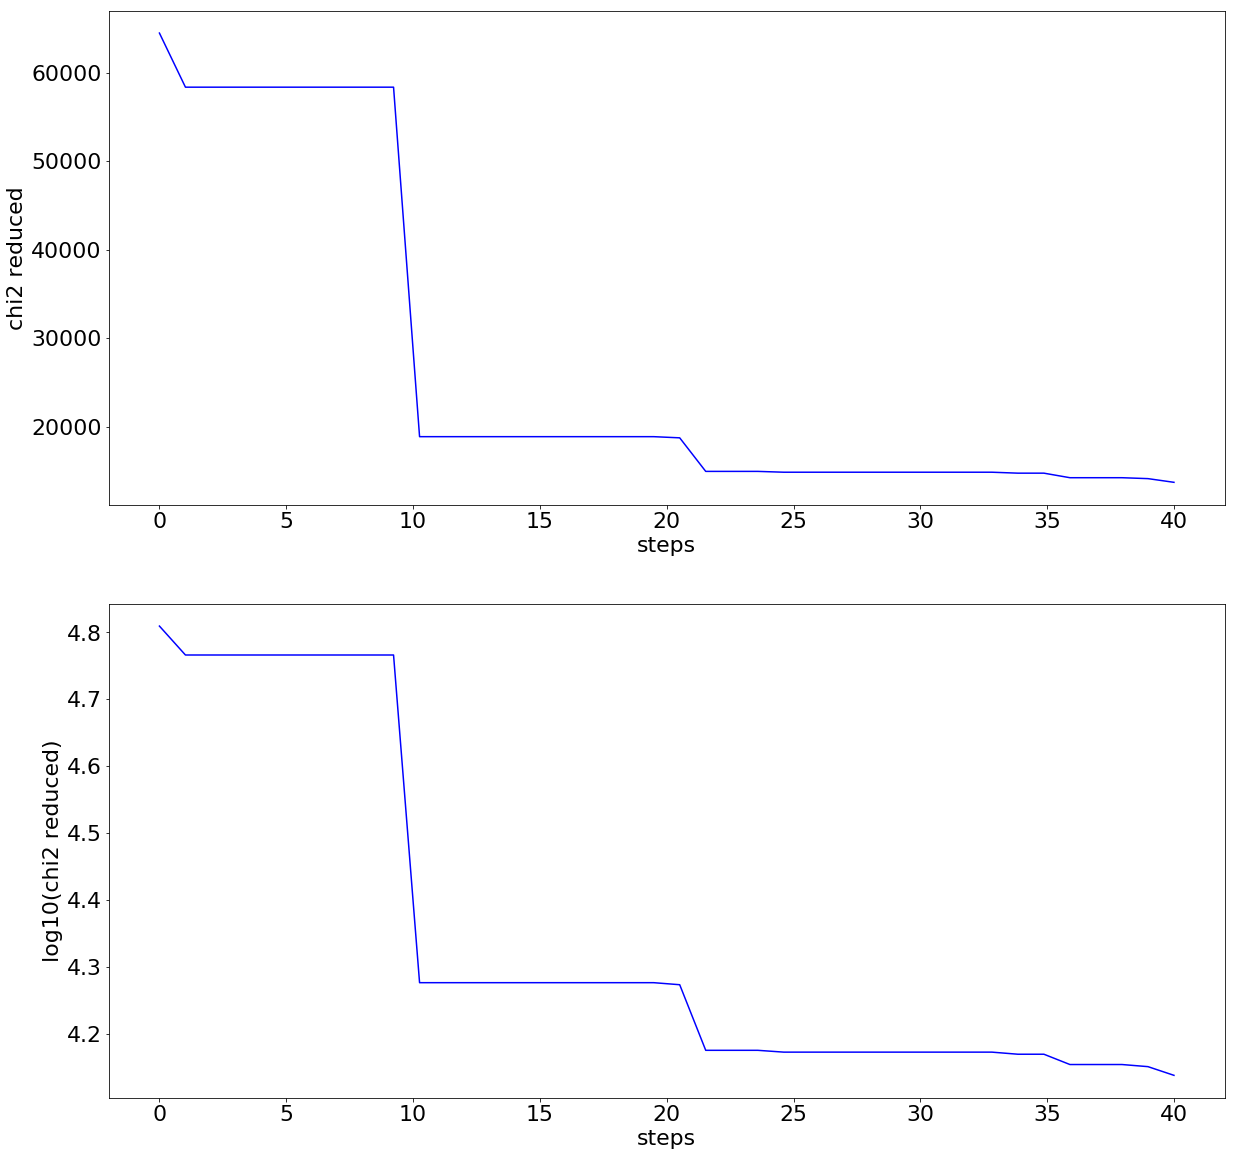

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(0,len(like_min),len(like_min)),like_min,'blue',ls='-')
plt.ylabel('chi2 reduced')
plt.xlabel('steps')
plt.subplot(212)
plt.plot(np.linspace(0,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(chi2 reduced)')
plt.xlabel('steps')

In [27]:
zparameters=minchain[0:8]
globalparameters=minchain[8:]


if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1)   

x=LN_PFS_single(sci_image,var_image).create_x(zparameters,globalparameters)

In [28]:
model(x)

oversampling of optPSF is: 40.0271421218
oversampling of optPsf_downsampled is: 10


-13722.306054419932

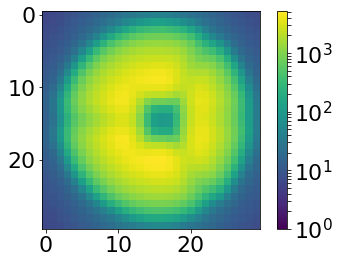

In [29]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')

plt.imshow(optPsf_cut_fiber_convolved_downsampled,norm=LogNorm(),vmax=np.max(optPsf_cut_fiber_convolved_downsampled),vmin=1)
plt.colorbar()

chi**2 reduced is: 30.4768541876
Abs of residual divided by total flux is: 0.11189335973
Abs of residual divided by largest value of a flux in the image is: 0.221215977412


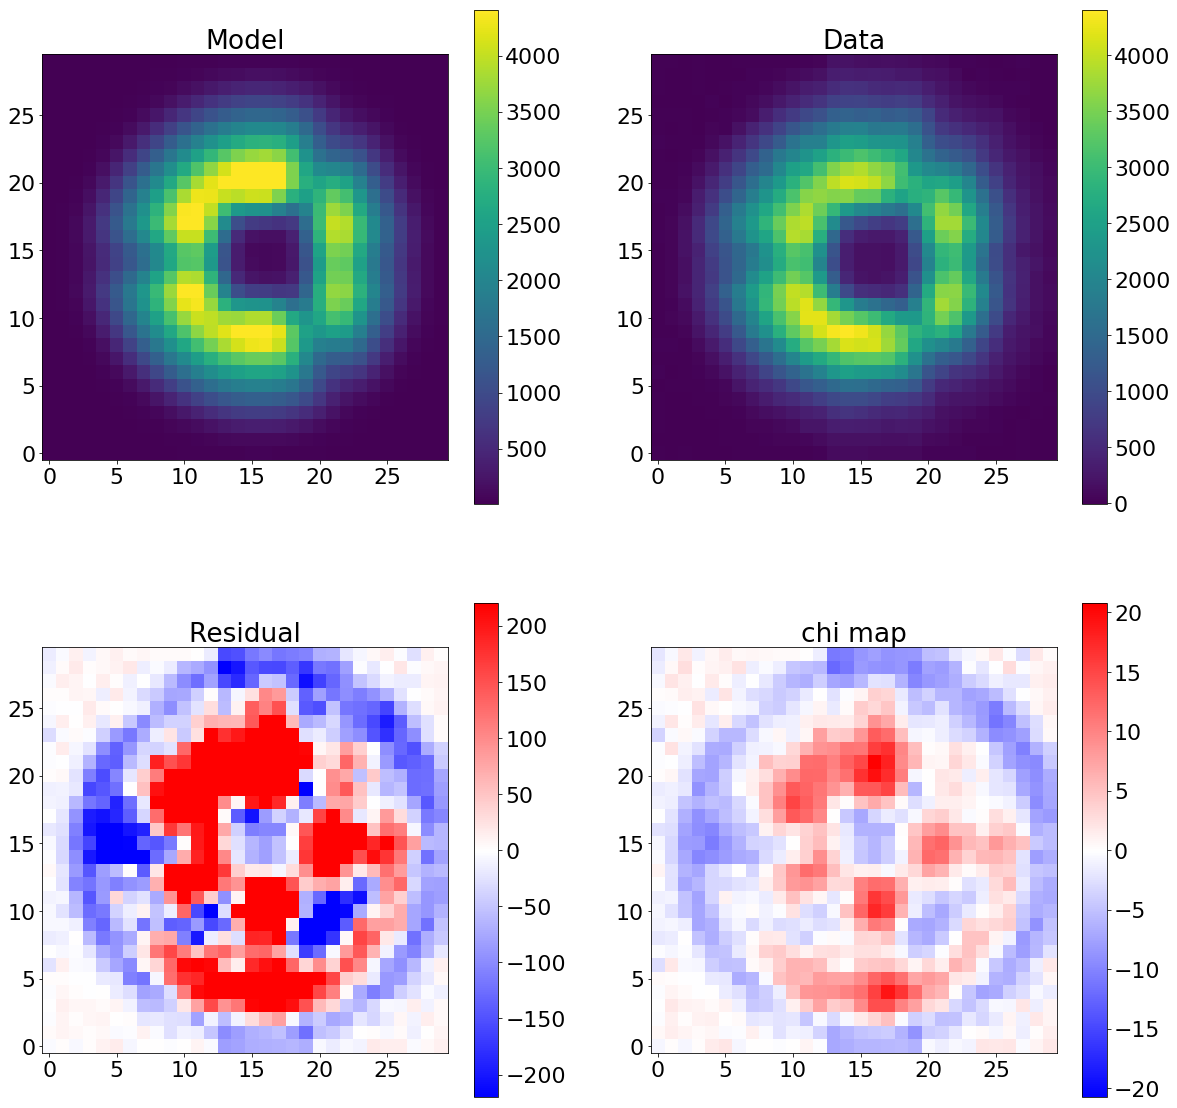

In [30]:
res_iapetus=optPsf_cut_fiber_convolved_downsampled
inputimage=sci_image
var_inputimage=var_image


plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(inputimage,origin='lower',vmax=np.max(np.abs(inputimage)))
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(res_iapetus-inputimage,origin='lower',cmap='bwr',vmin=-np.max(np.abs(inputimage))/20,vmax=np.max(np.abs(inputimage))/20)
plt.colorbar()
plt.title('Residual')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus-inputimage)/np.sqrt(var_inputimage),origin='lower',cmap='bwr',vmax=np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))),vmin=-np.max(np.abs((res_iapetus-inputimage)/np.sqrt(var_inputimage))))
plt.colorbar()
plt.title('chi map')
print('chi**2 reduced is: '+str(np.sum((res_iapetus-inputimage)**2/((var_inputimage.shape[0]*var_inputimage.shape[1])*var_inputimage))))
print('Abs of residual divided by total flux is: '+str(np.sum(np.abs((res_iapetus-inputimage)))/np.sum((res_iapetus))))
print('Abs of residual divided by largest value of a flux in the image is: '+str(np.max(np.abs((res_iapetus-inputimage)/np.max(res_iapetus)))))

# Analysis 

In [39]:
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(1)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8564,8615,8612]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 175 1\n")
    file.close()
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(2)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8600,8573,8606]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 175 1\n")
    file.close()
    
for single_spot in [55]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Perseus'+str(3)+'Spot'+str(single_spot)+'AugObs_P.sh','w') 
    
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=9 # node count \n")
    file.write("#SBATCH --ntasks-per-node=24 \n") 
    file.write("#SBATCH --time 14:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")

    for obs in [8570,8609,8567]:

        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_11_Mix_P_Aug.py "+str(obs)+" "+str(single_spot)+" 175 1\n")
    file.close()    
    
    

In [40]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/AugustScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for obs in [1,2,3]:
    for single_spot in [55]:
        file.write('sbatch /home/ncaplar/Scripts/Perseus'+str(obs)+'Spot'+str(single_spot)+'AugObs_P.sh \n')

file.close()

In [ ]:
inputimage